In [72]:
if '__IPYTHON__' in globals():
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path

from sklearn.metrics import RocCurveDisplay,ConfusionMatrixDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    average_precision_score,
    roc_auc_score,
    brier_score_loss,
    matthews_corrcoef,
    f1_score,
)

from sklearn import set_config
set_config(display="diagram")

### 1. Import data

In [73]:
target = "Survived"
random_state = 5646
test_size = 0.3
n_estimators = 200
min_samples_split = 20


In [74]:
df = pd.read_csv("../data/raw/train.csv")
X, y = (
    df.drop(target, axis=1),
    df.pop(target),
)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size, stratify=y)

### 2. Prepare data

In [76]:
def identify_deck(X, fill_missing="UNK"):
    # Create Deck column
    X = X["Cabin"].str[0]
    X = X.fillna(fill_missing)
    return np.array(X).reshape(-1, 1)

def fill_by_group(X, group_by, fill_by="median"):    
    X["Age"] = X["Age"].fillna(X.groupby(group_by)["Age"].transform(fill_by))
    return np.array(X["Age"]).reshape(-1, 1)

def count_features(X, offset=0):
    X = X.apply(lambda x: x.sum(), axis=1) + offset
    return np.array(X).reshape(-1, 1)


def discretize_feature(X, bins=[0,1], labels=None):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    X = X.apply(lambda x: pd.cut(x, bins=bins, include_lowest=True,labels=labels))
    return np.array(X).reshape(-1, 1)

def boolean_feature(X):
    X = X.apply(lambda x: x.sum() == 0, axis=1).astype(int)
    return np.array(X).reshape(-1, 1)

def extract_titles(X):
    X = X.apply(lambda x: x.str.extract(" ([A-Za-z]+)\.", expand=False))
    return np.array(X).reshape(-1, 1)


### 3. Create the pipeline

In [77]:
# Perform imputation
data_pipeline = make_column_transformer(
    # Create the familysize feature
    (FunctionTransformer(count_features, kw_args={"offset": 1}), ["SibSp", "Parch"]),
    # Create is_alone feature
    (FunctionTransformer(boolean_feature), ["SibSp", "Parch"]),
    # Create the title feature
    (
        make_pipeline(
            FunctionTransformer(extract_titles),
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        ),
        ["Name"],
    ),
    # Create the deck feature
    (
        make_pipeline(
            FunctionTransformer(identify_deck), OrdinalEncoder(categories="auto")
        ),
        ["Cabin"],
    ),

    # Create the fare_band feature
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            FunctionTransformer(
                discretize_feature,
                kw_args=dict(
                    bins=[0, 8, 15, 32, 100, 600],
                    labels=["Very Low", "Low", "Medium", "High", "Very High"],
                ),
            ),
            OrdinalEncoder(
                categories=[["Very Low", "Low", "Medium", "High", "Very High"]]
            ),
        ),
        ["Fare"],
    ),
    # Create the age_band feature
    (
        make_pipeline(
            FunctionTransformer(
                fill_by_group, kw_args=dict(group_by="Pclass", fill_by="median")
            ),
            FunctionTransformer(
                discretize_feature,
                kw_args=dict(
                    bins=[0, 14, 24, 64, 150],
                    labels=["Children", "Youth", "Adults", "Seniors"],
                ),
            ),
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        ),
        ["Age", "Pclass"],
    ), 
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        ),
        ["Embarked", "Sex", "Pclass"],
    ),
    ("passthrough", ["SibSp", "Parch"])
)


### 4. Create the model

In [78]:
model = RandomForestClassifier(
    n_estimators=n_estimators,
    random_state=random_state,
    min_samples_split=min_samples_split,
)

### 5. Validation

In [79]:
# Transform data
X_train_features = data_pipeline.fit_transform(X_train)
X_test_features = data_pipeline.transform(X_test)

# Metrics to evaluate the model
scoring = ("accuracy", "average_precision", "neg_brier_score", "roc_auc", "f1")

# Cross validation
scores = cross_validate(
    model, X_train_features, y_train, cv=5, scoring=scoring, n_jobs=-1
)

# Mean value of the metrics
for k, v in scores.items():
    #print(f"{k}: {v.mean():0.4f} (std {v.std():0.4f})")
    print ("{:<25} {:<8.4f} {:<4.4f}".format( k, v.mean(), v.std()))


fit_time                  0.1714   0.0176
score_time                0.0285   0.0036
test_accuracy             0.8105   0.0407
test_average_precision    0.8331   0.0587
test_neg_brier_score      -0.1368  0.0245
test_roc_auc              0.8605   0.0435
test_f1                   0.7344   0.0557


Accuracy:      0.8172 
Avg Precision: 0.8418 
F1-score:      0.7610 
Brier Score:   0.1304 
MCC:           0.6130 
ROC_AUC:       0.8753


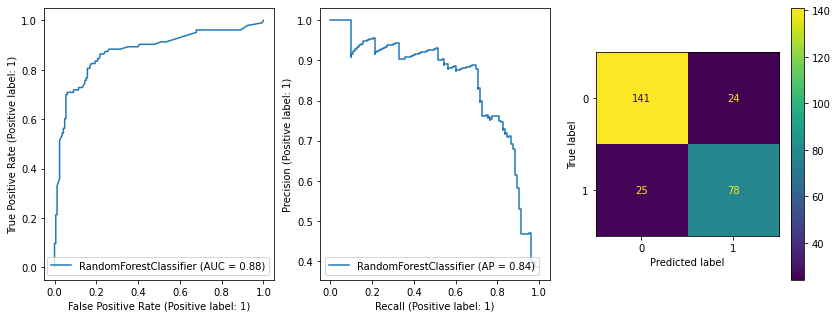

In [80]:
model.fit(X_train_features, y_train)

y_pred = model.predict(X_test_features)
y_pred_proba = model.predict_proba(X_test_features)[:, 1]


# Accuracy
acc = accuracy_score(y_test, y_pred)

# F1-score
f1 = f1_score(y_test, y_pred)

# Brier Score
brier = brier_score_loss(y_test, y_pred_proba)

# Matthews Correlation Coefficient
matthews = matthews_corrcoef(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred_proba)

avg_prec = average_precision_score(y_test, y_pred_proba)



print("Accuracy:      {:<.4f} \nAvg Precision: {:<.4f} \nF1-score:      {:<.4f} \nBrier Score:   {:<.4f} \nMCC:           {:<.4f} \nROC_AUC:       {:<.4f}".format(acc, avg_prec, f1, brier, matthews, roc_auc))




fig, ax = plt.subplots(1, 3, figsize=(14, 5))
RocCurveDisplay.from_estimator(model, X_test_features, y_test, ax=ax[0])
PrecisionRecallDisplay.from_estimator(model, X_test_features, y_test, ax=ax[1])
ConfusionMatrixDisplay.from_estimator(model, X_test_features, y_test, ax=ax[2])
plt.show()

In [81]:
test = pd.read_csv("../data/raw/test.csv")
test_features = data_pipeline.transform(test)

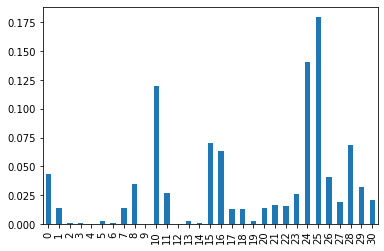

In [82]:
model.fit(X_train_features, y_train)
pd.Series(model.feature_importances_).plot(kind='bar')
y_test_pred = model.predict(test_features)

In [83]:
with tempfile.TemporaryDirectory() as temp_dir:

    # Download the submission template file to the temporary directory
    ! kaggle competitions download -c titanic -f gender_submission.csv --path={temp_dir}
    # Fill the template with the model predictions

    template = Path(f"{temp_dir}/gender_submission.csv").resolve()
    predictions = Path(f"{temp_dir}/{model.__class__.__name__}.csv").resolve()

    submission = pd.read_csv(template)
    submission[target] = y_test_pred
    submission.to_csv(predictions, index=False)

    # Save the submission file on the temporary directory
    ! kaggle competitions submit titanic -f {predictions} -m "RFC" 

  0%|                                               | 0.00/3.18k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 3.18k/3.18k [00:00<00:00, 6.95MB/s]
100%|██████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 1.56kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster